# ACTUAL STUFF

In [ ]:
# import os
# import torch

# import numpy as np
# from torchvision.io import read_image
# from torchvision import tv_tensors
# from torchvision.transforms.v2 import functional as F


# class DetectDataset(torch.utils.data.Dataset):
#     def __init__(self, root, transforms):
#         self.root = root
#         self.transforms = transforms
#         self.img_names = list(os.listdir(os.path.join(root, "images")))

#     def __getitem__(self, idx):
#         # load images and boxes
#         img_name = self.img_names[idx]
#         boxes_name = img_name[:-4] + '.txt'
#         img_path = os.path.join(self.root, "images", img_name)
#         boxes_path = os.path.join(self.root, "labels", boxes_name)
#         img = read_image(img_path)
#         boxes = np.loadtxt(boxes_path)

#         # get num objexts, image_id, area and iscrowd
#         labels = torch.ones((num_objs,), dtype=torch.int64) # there is only one class
#         num_objs = len(boxes) # number of objects in image
#         image_id = idx # doesnt matter
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # area of box
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64) # just set to zero

#         # Wrap sample and targets into torchvision tv_tensors:
#         img = tv_tensors.Image(img)

#         target = {}
#         target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

#         if self.transforms is not None:
#             img, target = self.transforms(img, target)

#         return img, target

#     def __len__(self):
#         return len(self.img_names)

In [45]:
# how to define dataset: https://pytorch.org/vision/main/models/generated/torchvision.models.detection.ssdlite320_mobilenet_v3_large.html
# follow link and click on See ssd300_vgg16() for more details.

import os
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


class DetectDataset(Dataset):
    def __init__(self, root, inds):
        self.root = root
        self.img_names = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.img_names = [self.img_names[i] for i in inds]

    def __getitem__(self, idx):
        # load images and boxes
        img_name = self.img_names[idx]
        boxes_name = img_name[:-4] + '.txt'
        img_path = os.path.join(self.root, "images", img_name)
        boxes_path = os.path.join(self.root, "labels", boxes_name)
        img = Image.open(img_path).convert("RGB")       
        boxes = np.loadtxt(boxes_path)
        if boxes.ndim == 1:
            boxes = boxes[None, :]
        labels = torch.ones((len(boxes),), dtype=torch.int64) # there is only one class

        target = {}
        target["boxes"] = torch.from_numpy(boxes)
        target["labels"] = labels

        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.img_names)

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
base_dir = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment'
images_dir = os.path.join(base_dir, 'images')
train_inds, val_inds = train_test_split(range(len(os.listdir(images_dir))), test_size=0.1)


def custom_collate(data):
    return data

trainset = DetectDataset(base_dir, train_inds)
valset = DetectDataset(base_dir, val_inds)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=custom_collate)
valloader = DataLoader(valset, batch_size=16, collate_fn=custom_collate)

In [47]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights

# # bigger model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1).to(device)
# num_classes = 2 # background is also a class here
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)


# smaller model
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=torchvision.models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT, trainable_backbone_layers=5).to(device)
num_classes = 2  # 1 class (your class) + 1 class (background)
model.head.classification_head.num_classes = num_classes

In [48]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=0.001)

In [49]:
len(trainset)

873

In [50]:
len(valset)

98

In [51]:
num_epochs = 20



for epoch in range(num_epochs):
    train_epoch_loss = 0
    model.train()

    for data in trainloader:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['labels'].to(device)
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # train_epoch_loss = train_epoch_loss / len(trainset)

    
    if epoch % 1 == 0:
        val_epoch_loss = 0

        with torch.no_grad():
            for data in valloader:
                imgs = []
                targets = []
                for d in data:
                    imgs.append(d[0].to(device))
                    targ = {}
                    targ['boxes'] = d[1]['boxes'].to(device)
                    targ['labels'] = d[1]['labels'].to(device)
                    targets.append(targ)

                loss_dict = model(imgs, targets)
                loss = sum(v for v in loss_dict.values())
                val_epoch_loss += loss.cpu().detach().numpy()
            
            # val_epoch_loss = val_epoch_loss / len(valset)
    
    print(f'trainloss: {train_epoch_loss}')
    print(f'valloss: {val_epoch_loss}')

AssertionError: All bounding boxes should have positive height and width. Found invalid box [292.0, 88.40000131726265, 27.5, 50.80000075697899] for target at index 0.

In [136]:
model.eval()
data = next(iter(valloader))


In [137]:
img = data[0][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['labels']

In [138]:
output = model([img.to(device)])

In [139]:
output

[{'boxes': tensor([[ 66.3785, 149.8098, 170.1534, 270.7100],
          [323.5798,  69.5732, 462.0901, 160.6879],
          [ 99.1912, 298.4297, 222.0603, 376.1382],
          [447.5157, 123.3887, 554.8962, 184.6376],
          [ 86.9529,  19.7145, 248.3017,  78.1995],
          [ 25.8557, 305.3485, 132.1509, 370.6415],
          [243.6201,  30.5658, 295.6194, 160.3084],
          [557.4489,  79.6067, 639.7755, 139.9002],
          [441.8201,  82.8784, 552.7933, 133.2124],
          [ 43.8145,  28.7345, 216.2264,  89.3405],
          [ 39.1859,  34.8205, 142.4402,  89.3279],
          [444.7334,  99.9624, 554.0266, 162.1340],
          [ 44.8777,  20.8889, 270.5256, 107.0486],
          [591.8589,  71.3545, 639.6797, 134.1243],
          [498.3378,  82.1401, 615.9760, 134.5982],
          [602.1251, 294.0123, 637.3687, 367.9832],
          [587.0870,  43.9892, 640.0000, 114.9778],
          [395.9879, 124.7752, 552.8916, 206.0572],
          [261.3148,  37.2024, 315.4426, 126.8498],
   

In [140]:
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']
keep = torchvision.ops.nms(out_bbox, out_scores, 0.4)
keep = keep.detach().cpu().numpy()

In [141]:
out_bbox.shape, keep.shape

(torch.Size([54, 4]), (33,))

In [142]:
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')

In [143]:
import PIL

In [144]:
keep

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 14, 15, 16, 18, 20, 21, 24,
       26, 27, 29, 30, 31, 34, 35, 36, 37, 40, 41, 43, 46, 47, 48, 53])

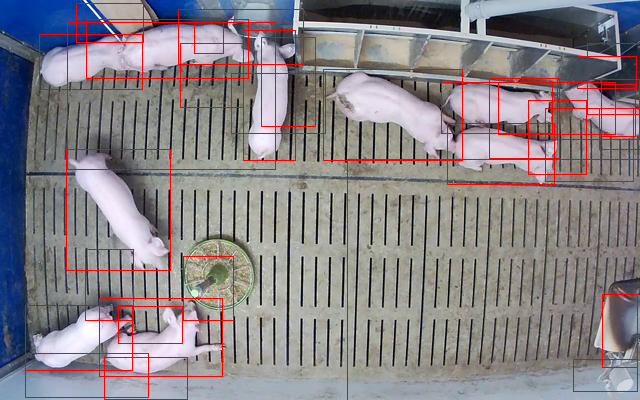

In [145]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

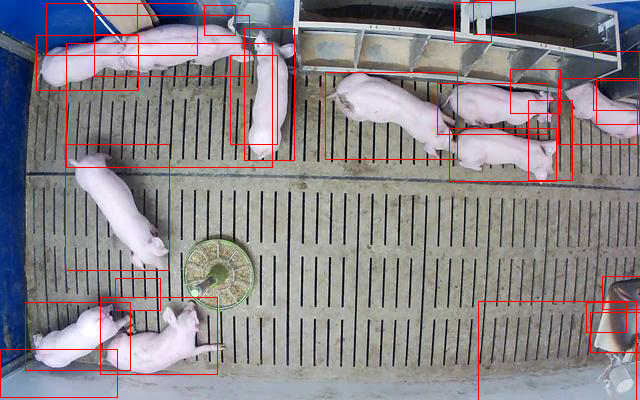

In [106]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

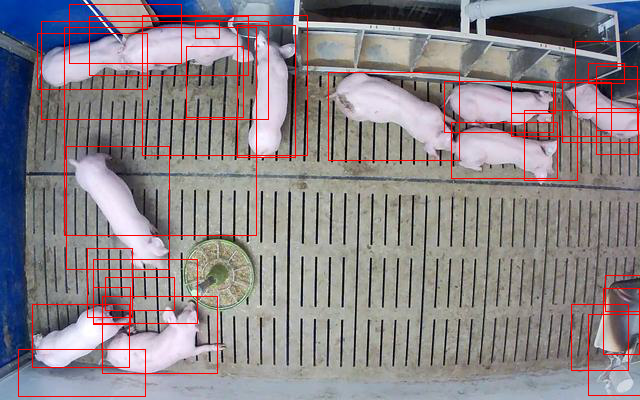

In [90]:
vsample = Image.fromarray(im)

draw = PIL.ImageDraw.Draw(vsample)

for box in out_bbox[keep]:
    draw.rectangle(list(box), fill=None, outline='red')

vsample

# HUGGING FACE DETR

In [5]:
from datasets import load_dataset
import os

base_dir = '/usr/users/henrich1/exercises_summer_school/data/detect_and_segment'
train_path = os.path.join(base_dir, 'train.csv')
val_path = os.path.join(base_dir, 'val.csv')
data_files = {
    'train': train_path,
    'val': val_path
}

dataset = load_dataset("csv", data_files=data_files)
print(dataset['train'])
print(dataset['val'])

id2label = {0: 'pig'}
label2id = {'pig': 0}

Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 873
})
Dataset({
    features: ['image_id', 'image_name'],
    num_rows: 98
})


In [6]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [7]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(400, 640),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [8]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(len(category)):

        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0, # no background class
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [9]:
# base_dir = '/usr/users/henrich1/exercises_summer_school/dev/detect_and_segment_dev/labels_yolo'

# for label_name in os.listdir(base_dir):
#     label_path = os.path.join(base_dir, label_name)
#     label = np.loadtxt(label_path)
#     if label.ndim == 1:
#         label = label[None, :]
#     assert (label[:, 3] <= 1).sum() == len(label)
#     assert (label[:, 4] <= 1).sum() == len(label)

In [10]:
from PIL import Image

# transforming a batch # HIER WEITER
def transform_aug_ann(examples, base_dir):
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')
    image_ids = examples["image_id"]
    images, bboxes, areas, categories = [], [], [], []
    
    for image_name in examples["image_name"]:
        image = Image.open(os.path.join(images_dir, image_name + '.jpg'))
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        
        bbox = np.loadtxt(os.path.join(labels_dir, image_name + '.txt'))
        if bbox.ndim == 1:
            bbox = bbox[None, :]
        category = [0 for _ in range(len(bbox))] # only one class
        out = transform(image=image, bboxes=bbox, category=category)
        area = np.array(out["bboxes"])[:, 2] * np.array(out["bboxes"])[:, 3]

        areas.append(area)
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, areas, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [11]:
dataset['train'] = dataset['train'].with_transform(lambda examples: transform_aug_ann(examples, base_dir))


In [12]:
dataset['train'][0]['labels']

{'size': tensor([ 800, 1280]), 'image_id': tensor([11]), 'class_labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]), 'boxes': tensor([[0.6148, 0.3819, 0.1063, 0.1163],
        [0.6895, 0.2025, 0.1305, 0.0850],
        [0.5281, 0.4381, 0.0359, 0.1887],
        [0.6629, 0.6263, 0.0477, 0.0950],
        [0.9762, 0.6156, 0.0461, 0.1312],
        [0.9816, 0.4750, 0.0352, 0.0700],
        [0.1109, 0.2600, 0.0766, 0.1975],
        [0.7480, 0.4956, 0.1227, 0.1737],
        [0.3590, 0.6044, 0.1086, 0.1538],
        [0.6355, 0.3181, 0.0727, 0.1037],
        [0.0828, 0.6513, 0.0672, 0.1700],
        [0.5445, 0.2688, 0.1125, 0.1625],
        [0.6066, 0.5219, 0.0633, 0.1912],
        [0.3313, 0.5300, 0.1547, 0.1125],
        [0.8633, 0.6206, 0.0453, 0.1612],
        [0.8207, 0.6156, 0.0602, 0.1688],
        [0.0598, 0.4625, 0.0492, 0.2125],
        [0.6270, 0.6037, 0.0992, 0.2200],
        [0.0988, 0.4575, 0.0617, 0.2025],
        [

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [14]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=4,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import torch

In [4]:
test = torch.randn(500).cuda()

In [ ]:
from transformers import Trainer
# torch.cuda.set_device(7)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.args._n_gpu = 1
trainer.train()

# scrap

In [6]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")
cppe5

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [7]:
x = cppe5["train"][0]['objects']['bbox']

In [9]:
x[0]

[302.0, 109.0, 73.0, 52.0]

In [8]:
list(x[0])

[302.0, 109.0, 73.0, 52.0]

# Segment anything

In [96]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-02-12 19:13:26--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Auflösen des Hostnamens dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)… 52.222.236.65, 52.222.236.115, 52.222.236.74, ...
Verbindungsaufbau zu dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.65|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 2564550879 (2,4G) [binary/octet-stream]
Wird in »sam_vit_h_4b8939.pth« gespeichert.

sam_vit_h_4b8939.pt 100%[===================>]   2,39G   107MB/s    in 28s     

2024-02-12 19:14:12 (87,1 MB/s) - »sam_vit_h_4b8939.pth« gespeichert [2564550879/2564550879]

